# Morphological Measurements of Buildings using Momepy 

*Code version: 0.1*

In [24]:
# Import libraries 
print("Installing packages.......")
import numpy as np
import tqdm
from tqdm import trange

import geopandas as gpd 
import pygeos
import itertools
import geopandas as gpd
import seaborn as sns

import scipy as sp
import momepy as mm
import matplotlib.pyplot as plt

from libpysal.weights import Queen, DistanceBand
print("Libraries & packages installed and imported !!!!")

Installing packages.......
Libraries & packages installed and imported !!!!


<AxesSubplot:>

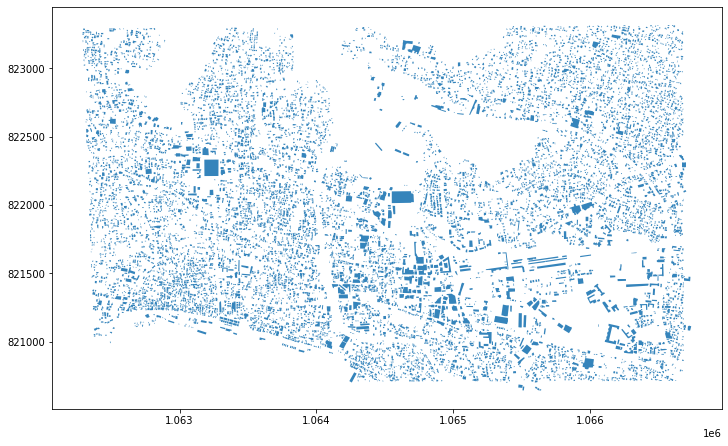

In [25]:
# Import building shapefile
df = gpd.read_file("C:/Msc Research/Thesis Phase/Detection Phase 2/Kollam/Predictions/kollam_buildings_project.shp").explode().reset_index(drop=True)

# Plot shapefile
df.plot(figsize=(12,12), alpha=0.9)

## Pre-processing the shapefile data

Clean the shapefile polygons of faulty polygons, multi-polygons and false postivies as a results of the predictions

In [26]:
# Generate a function to close gaps and remove faulty polygons

def fill_insides(df):
    """
    1. Remove faulty polygons inside other.
    2. Close gaps.
    """
    polys = pygeos.polygons(pygeos.get_exterior_ring(df.geometry.values.data))
    inp, res = pygeos.STRtree(polys).query_bulk(polys, predicate='contains_properly')
    cleaner = np.delete(polys, res)
    return gpd.GeoSeries(cleaner, crs=df.crs)

<AxesSubplot:>

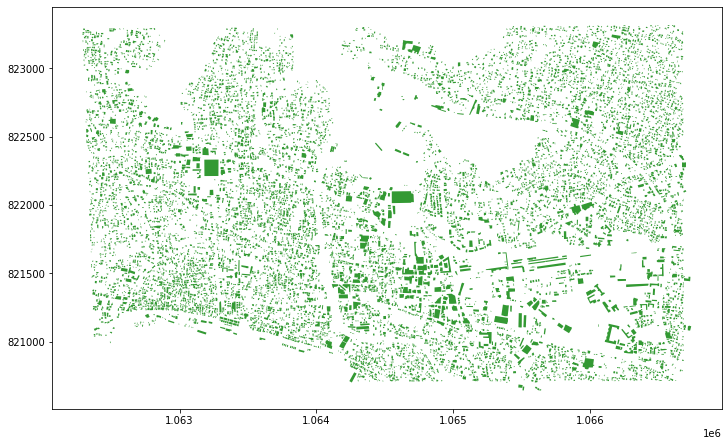

In [27]:
fill_insides(df).plot(figsize=(12,12), alpha=.8, color="Green")

**Remove noise, i.e. polygons smaller than a certain sqm.**

In [28]:
# Convert the data from a Gegraphical Coordinate System to a Coordinate Reference System (CRS) as GeoPandas reads CRS data
df = df.to_crs(epsg=7781) # EPSG 7781 belongs to Kerala

In [29]:
# Remove false positives by filtering
(df.area < 5).sum() / len(df)
clean_plyg = df[df.area > 30] # <30 sqm building area are removed here to filter false positives

<AxesSubplot:>

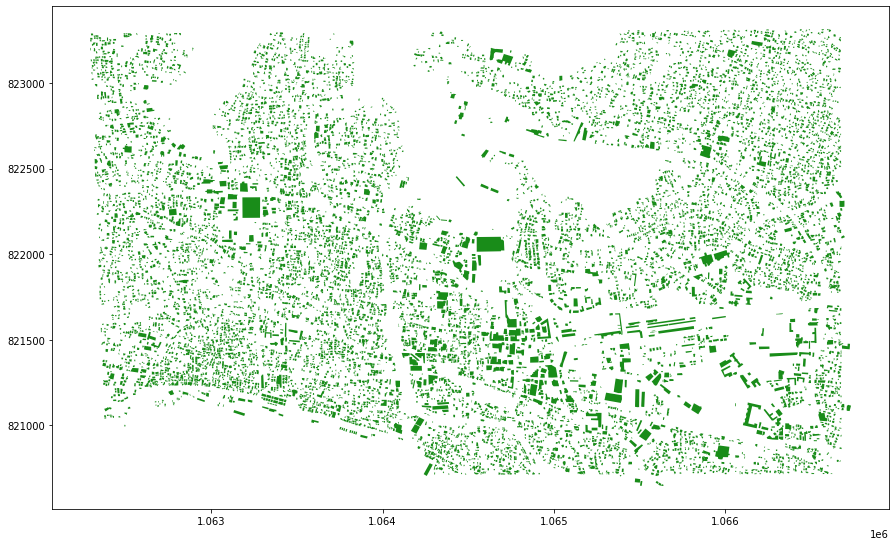

In [30]:
clean_plyg.plot(figsize=(15,15), alpha=0.9, color="Green")

In [33]:
# View as a table
clean_plyg

,raster_val,Area,geometry
0,1.0,33.0573,"POLYGON ((1066490.667 823313.547, 1066491.257 ..."
1,1.0,49.7938,"POLYGON ((1066604.094 823314.622, 1066604.241 ..."
2,1.0,70.1620,"POLYGON ((1066575.184 823314.130, 1066575.627 ..."
3,1.0,78.1911,"POLYGON ((1066245.818 823312.555, 1066245.965 ..."
4,1.0,83.2230,"POLYGON ((1066445.679 823313.770, 1066447.744 ..."
...,...,...,...
10228,0.0,0.0000,"POLYGON ((1065280.864 821003.978, 1065288.847 ..."
10229,0.0,0.0000,"POLYGON ((1065303.777 820996.252, 1065314.114 ..."
10230,0.0,0.0000,"POLYGON ((1065285.898 820965.959, 1065312.987 ..."
10231,0.0,0.0000,"POLYGON ((1065221.876 820985.726, 1065255.638 ..."


In [34]:
# Check if there are overlaps (could cause issues with morpohlogical tessellation)
inp, res = clean_plyg.sindex.query_bulk(clean_plyg.geometry, predicate='overlaps')

print(f"There are {len(res)} overlaps of polygons in the study area.")

There are 333 overlaps of polygons in the study area.


In [35]:
# Check validity
clean_plyg.is_valid.all()

False

In [37]:
# If validity is reported as False, then try this: 
# Remove ".loc" and run the cell, then add .loc and re-run the cell 
clean_plyg.loc.geometry = clean_plyg.buffer(0)
clean_plyg.is_valid.all()

True

In [38]:
# Check the geometry types
clean_plyg.geom_type.value_counts()

Polygon    9720
dtype: int64

In [39]:
# Remove multi-polygons (Should be resolved during the geometry creation similarly to overlaps)
clean_plyg = clean_plyg[clean_plyg.geom_type == "Polygon"] 

In [40]:
# Rest the index just to be sure
clean_plyg = clean_plyg.reset_index(drop=True)

## Generate Morphological Tessellation

Momepy is a library for quantitative analysis of urban form - urban morphometrics. It is built on top of GeoPandas, [PySAL](http://pysal.org/) and [networkX](https://networkx.org/).

Some of the functionality that momepy offers:

1. Measuring dimensions of morphological elements, their parts, and aggregated structures.

2. Quantifying shapes of geometries representing a wide range of morphological features.

3. Capturing spatial distribution of elements of one kind as well as relationships between different kinds.

4. Computing density and other types of intensity characters.

5. Calculating diversity of various aspects of urban form.

6. Capturing connectivity of urban street networks

7. Generating relational elements of urban form (e.g. morphological tessellation)

![picture](https://drive.google.com/uc?export=view&id=1yv4oWLP_1qEcLQitLer4QZ88xJuiKyZi)

In [42]:
clean_plyg["uID"] = range(len(clean_plyg))
clean_plyg_limit = mm.buffered_limit(clean_plyg, 55) #25
clean_plyg_tess = mm.Tessellation(clean_plyg, "uID", clean_plyg_limit, verbose=True).tessellation

Inward offset...
Generating input point array...
Generating Voronoi diagram...
Generating GeoDataFrame...
Dissolving Voronoi polygons...


In [43]:
# Remove multi-polygons (Should be resolved during the geometry creation similarly to overlaps)
clean_plyg = clean_plyg[clean_plyg.geom_type == "Polygon"] 
clean_plyg_tess = clean_plyg_tess[clean_plyg_tess.geom_type == "Polygon"]

<AxesSubplot:>

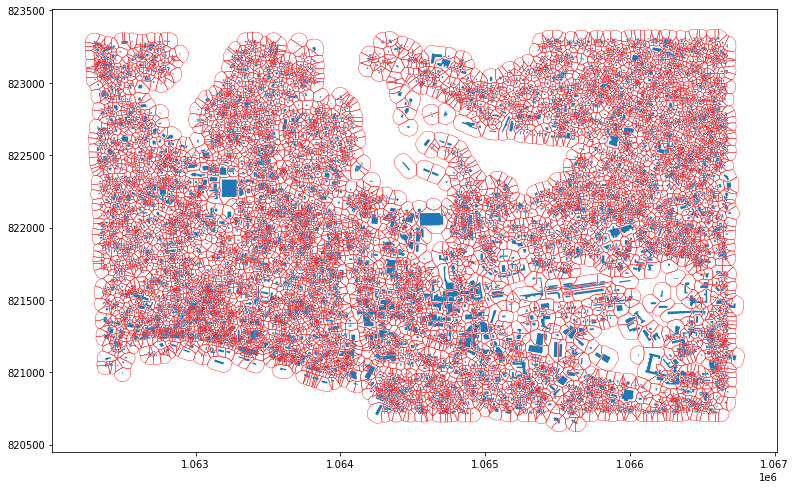

In [44]:
ax = clean_plyg.plot(figsize=(13,13))
clean_plyg_tess.plot(ax=ax, facecolor="none", edgecolor="r", linewidth=0.4)

## Measuring primary morphometric characters

Measure a selection of metrics which works with building footprint and tessellation inputs.

In [45]:
# Create the columns required for the morphological metrics

# Dimensions
clean_plyg["sdbAre"] = mm.Area(clean_plyg).series
clean_plyg["sdbPer"] = mm.Perimeter(clean_plyg).series

# Shapes
# clean_plyg["ssbCCo"] = mm.CircularCompactness(clean_plyg, "sdbAre").series
clean_plyg["ssbCor"] = mm.Corners(clean_plyg).series
clean_plyg["ssbSqu"] = mm.Squareness(clean_plyg).series
clean_plyg["ssbERI"] = mm.EquivalentRectangularIndex(clean_plyg, "sdbAre", "sdbPer").series
clean_plyg["ssbElo"] = mm.Elongation(clean_plyg).series
cencon = mm.CentroidCorners(clean_plyg)
clean_plyg["ssbCCM"] = cencon.mean
clean_plyg["ssbCCD"] = cencon.std

# Spatial distribution
clean_plyg["stbOri"] = mm.Orientation(clean_plyg).series
clean_plyg_tess["stcOri"] = mm.Orientation(clean_plyg_tess).series
clean_plyg["stbCeA"] = mm.CellAlignment(clean_plyg, clean_plyg_tess, "stbOri", "stcOri", "uID", "uID").series

# Tessellation dimensions and shapes
clean_plyg_tess["sdcLAL"] = mm.LongestAxisLength(clean_plyg_tess).series
clean_plyg_tess["sdcAre"] = mm.Area(clean_plyg_tess).series
clean_plyg_tess["sscCCo"] = mm.CircularCompactness(clean_plyg_tess, "sdcAre").series
clean_plyg_tess["sscERI"] = mm.EquivalentRectangularIndex(clean_plyg_tess, "sdcAre").series

# Intensity
clean_plyg_tess["sicCAR"] = mm.AreaRatio(clean_plyg_tess, clean_plyg, "sdcAre", "sdbAre", "uID").series

queen_1 = Queen.from_dataframe(clean_plyg_tess, ids="uID")

clean_plyg["mtbAli"] = mm.Alignment(clean_plyg, queen_1, "uID", "stbOri").series
clean_plyg["mtbNDi"] = mm.NeighborDistance(clean_plyg, queen_1, "uID").series
clean_plyg_tess["mtcWNe"] = mm.Neighbors(clean_plyg_tess, queen_1, "uID", weighted=True).series
clean_plyg_tess["mdcAre"] = mm.CoveredArea(clean_plyg_tess, queen_1, "uID").series

clean_plyg_queen = Queen.from_dataframe(clean_plyg, silence_warnings=True)

queen3 = mm.sw_high(k=3, weights=queen_1)

clean_plyg["ltbIBD"] = mm.MeanInterbuildingDistance(clean_plyg, queen_1, "uID", queen3).series
clean_plyg_tess["ltcBuA"] = mm.BuildingAdjacency(clean_plyg, queen3, "uID", clean_plyg_queen).series

  1%|▊                                                                            | 104/9720 [00:00<00:09, 1022.33it/s]

Computing mean interbuilding distances...


Calculating adjacency: 100%|███████████████████████████████████████████████████| 9720/9720 [00:00<00:00, 108290.13it/s]


In [46]:
# Check the newly created indices of the metrics
clean_plyg.columns 

Index(['raster_val', 'Area', 'geometry', 'uID', 'sdbAre', 'sdbPer', 'ssbCor',
       'ssbSqu', 'ssbERI', 'ssbElo', 'ssbCCM', 'ssbCCD', 'stbOri', 'stbCeA',
       'mtbAli', 'mtbNDi', 'ltbIBD'],
      dtype='object')

In [47]:
# Format as a table and remove the unnecessary columns
clean_data = clean_plyg_tess.drop(columns="geometry").merge(clean_plyg.drop(columns=["raster_val","Area", "geometry"]), on="uID")
# View the created table
clean_data

,uID,stcOri,sdcLAL,sdcAre,sscCCo,sscERI,sicCAR,mtcWNe,mdcAre,ltcBuA,...,ssbSqu,ssbERI,ssbElo,ssbCCM,ssbCCD,stbOri,stbCeA,mtbAli,mtbNDi,ltbIBD
0,0,5.460676,76.225230,2670.691952,0.585243,1.024824,0.012378,0.024403,10598.387677,1.0,...,2.241580e-07,0.825585,0.768971,3.289942,0.538934,0.093556,5.367121,17.834156,32.053255,20.409970
1,1,0.163313,78.121315,1519.715935,0.317054,0.981548,0.032765,0.016386,8891.981109,1.0,...,2.537822e-07,0.817116,0.750193,4.040502,0.693107,0.093719,0.069594,14.834755,14.299112,23.777377
2,2,0.803860,80.603397,3231.877288,0.633371,1.036207,0.021709,0.018172,9427.953606,1.0,...,2.745507e-07,0.737933,0.497899,5.144724,1.383485,2.013462,1.209602,11.012340,28.185854,21.041197
3,3,9.782089,77.762607,3182.512274,0.670098,1.045718,0.024569,0.023155,8078.455546,1.0,...,2.841136e-07,0.741711,0.501274,5.318434,1.801677,5.949055,3.833033,5.467343,14.380401,15.328196
4,4,21.654860,83.986724,3197.492579,0.577163,1.014027,0.026028,0.017815,8295.368046,1.0,...,2.372755e-07,0.845403,0.948399,5.281435,0.613882,15.936284,5.718577,12.649357,18.594592,21.538022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9715,9715,20.095815,68.214986,957.611920,0.262023,0.887948,0.218430,0.031932,15625.347174,1.0,...,2.336856e+00,1.000796,0.308454,13.604596,0.158054,0.946291,19.149525,2.758091,15.877704,20.759675
9716,9716,7.724318,60.798925,1611.394603,0.555035,1.025680,0.168666,0.036939,17788.311436,1.0,...,4.875281e+00,1.003525,0.372771,14.302013,0.389811,4.803854,2.920464,7.050966,26.806076,21.212846
9717,9717,5.468695,58.968895,1308.517356,0.479119,0.911785,0.392206,0.049244,7990.160134,1.0,...,3.121771e+00,0.997614,0.745203,16.418172,0.459991,4.746308,0.722387,2.290781,14.044010,18.330412
9718,9718,44.707470,63.831734,1976.998882,0.617793,1.048686,0.270032,0.023029,16138.894606,1.0,...,3.108190e-01,1.001368,0.465878,18.668254,0.040384,0.131726,44.575744,1.740963,12.071909,21.597356


In [50]:
# Save a csv file of the metrics 
clean_data.to_csv("C:/Msc Research/Thesis Phase/Characterisation Phase 2/Momepy/kollam_tess_55.csv")

clean_plyg_tess[["uID", "geometry"]].to_file("clean_plyg.shp", layer="tessellation")

# Save the polygon with the metrics
clean_plyg[["uID", "geometry"]].to_file("C:/Msc Research/Thesis Phase/Characterisation Phase 2/Momepy/kollam_tess_55.gpkg", driver="GPKG", layer="buildings")

In [49]:
# Save the obtained morphological metrics as figures in a folder 
for c in clean_data.columns[1:]:
    fig, axs = plt.subplots(1, 2, figsize=(24, 8))
    vmin = min([clean_data[c].min()])
    vmax = max([clean_data[c].max()])
    clean_plyg_tess.plot(clean_data[c], ax=axs[0], legend=True, vmin=vmin, vmax=vmax)
    axs[0].set_title('Buildings')
    fig.suptitle(c)
    plt.savefig(f'C:/Msc Research/Thesis Phase/Characterisation Phase 2/Momepy/Morphological Figures/{c}.png')
    plt.close()

## Contextual characters

Contextual characters are spatially lagged and express the tendency within the area. We will try two options - standard three topological steps and 100 distance threshold.

We will measure interquartile mean, interquartile range and interdecile Theil index of inequality.

**Standard three topological steps of Mean, Range and Theil Index**

In [ ]:
# Define the Theil index of inequality
def theil(y):
    y = np.array(y)
    n = len(y)
    plus = y + np.finfo('float').tiny * (y == 0)  # can't have 0 values
    yt = plus.sum(axis=0)
    s = plus / (yt * 1.0)
    lns = np.log(n * s)
    slns = s * lns
    t = sum(slns)
    return t

In [ ]:
means = {}
ranges = {}
theils = {}

for ch in clean_data.columns[1:]:
    means[ch] = []
    ranges[ch] = []
    theils[ch] = []
    
clean_data = clean_data.set_index("uID")

In [ ]:
spatial_weights = mm.sw_high(k=3, gdf=clean_plyg_tess, ids='uID')

for i in clean_data.index:
    neighbours = spatial_weights.neighbors[i].copy()
    neighbours.append(i)
    
    for ch in clean_data.columns[1:]:
        values_list = clean_data.loc[neighbours][ch]
        idec = mm.limit_range(values_list.tolist(), rng=(10, 90))
        iquar = mm.limit_range(values_list.tolist(), rng=(25, 75))
        
        means[ch].append(np.mean(iquar))
        ranges[ch].append(sp.stats.iqr(values_list, rng=(25, 75)))
        theils[ch].append(theil(idec))

for ch in clean_data.columns[1:]:
    clean_data[ch + '_meanIQ3'] = means[ch]
    clean_data[ch + '_rangeIQ3'] = ranges[ch]
    clean_data[ch + '_theilID3'] = theils[ch]

**Distance Band**

In [ ]:
means = {}
ranges = {}
theils = {}

for ch in clean_data.columns[1:23]:
    means[ch] = []
    ranges[ch] = []
    theils[ch] = []
    
spatial_weights = DistanceBand.from_dataframe(clean_plyg, 100, ids="uID")

for i in clean_data.index:
    neighbours = spatial_weights.neighbors[i].copy()
    neighbours.append(i)
    
    for ch in clean_data.columns[1:23]:
        values_list = clean_data.loc[neighbours][ch]
        idec = mm.limit_range(values_list.tolist(), rng=(10,90))
        iquar = mm.limit_range(values_list.tolist(), rng=(25,75))
        
        means[ch].append(np.mean(iquar))
        ranges[ch].append(sp.stats.iqr(values_list, rng=(25,75)))
        theils[ch].append(theil(idec))
        
for ch in clean_data.columns[1:23]:
    clean_data[ch + "meanIQ100"] = means[ch]
    clean_data[ch + "rangeIQ100"] = ranges[ch]
    clean_data[ch + "theilID100"] = theils[ch]

In [ ]:
cont = [c for c in clean_data.columns if "_" in c]
cont

In [ ]:
clean_data[cont].to_csv("C:/Msc Research/Thesis Phase/Characterisation Phase/Phase 1 (Momepy and OSM Tagging)/Momepy/Morphological Assessment/CSV/clean_lagged.csv")

In [ ]:
# Plots
for c in cont:
    fig, axs = plt.subplots(1, 2, figsize=(24, 8))
    vmin = min([clean_data[c].min()])
    vmax = max([clean_data[c].max()])
    clean_plyg_tess.plot(clean_data[c], ax=axs[0], legend=True, vmin=vmin, vmax=vmax)
    axs[0].set_title('Clean lagged buildings')
    fig.suptitle(c)
    plt.savefig(f'C:/Msc Research/Thesis Phase/Characterisation Phase/Phase 1 (Momepy and OSM Tagging)/Momepy/Morphological Assessment/Morphological figures/Figures 2/{c}.png')
    plt.close()